In [3]:
!pip install --upgrade numpy==1.17.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 43.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [2902 lines of output]
      Running from numpy source directory.
      blas_opt_info:
      blas_mkl_info:
      customize UnixCCompiler
        FOUND:
          libraries = ['mkl_rt', 'pthread']
          library_dirs = ['/opt/conda/lib']
          define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
          include_dirs = ['/usr/local/include', '/usr/include', '/opt/conda/include']
      
        FOUND:
          libraries = ['mkl_rt', 'pthread']
          library_dirs = ['/opt/conda/lib']
          define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
          include_dirs = ['/usr/local/include', '/usr/include', '/opt/conda/include']
      
      /bin/sh: 1: svnversion: not found
      non-existing path in 'numpy/

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import re, spacy

from time import time 

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')



In [5]:
data = pd.read_csv("../input/bengali-text-summarization/text_summarization.csv")
data.head()

,category,summary,text
0,technology,অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ..."
1,bangladesh,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...
2,bangladesh,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...
3,bangladesh,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...
4,bangladesh,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...


In [6]:
print("Shape of the dataset is :", data.shape)

Shape of the dataset is : (80331, 3)


In [7]:
data.head(10)

,category,summary,text
0,technology,অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ..."
1,bangladesh,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...
2,bangladesh,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...
3,bangladesh,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...
4,bangladesh,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...
5,bangladesh,‘বাল্যবিবাহমুক্ত’ জেলা ঘোষণা চলছে নিয়ম না মেনেই,পর্যাপ্ত তথ্য-উপাত্ত হাতে নিয়েই কোনো জেলা বা...
6,sports,পাকিস্তানি ক্রিকেটারদের দুটির বেশি টি-টোয়েন্টি...,বাংলাদেশ প্রিমিয়ার লিগে গতবার প্রতি ম্যাচে পাঁ...
7,bangladesh,চাটখিল উপজেলা ভাইস চেয়ারম্যান সন্ত্রাসী হামলার...,লক্ষ্মীপুরের পোদ্দার বাজারে সন্ত্রাসী হামলার শ...
8,bangladesh,ব্যবসায়ীদের চাপে জরিমানা কমাতে বাধ্য হলেন বিচারক,নিষিদ্ধ পলিথিন ব্যবসায় জড়িত থাকায় এক ব্যবসা...
9,bangladesh,নাইকো দুর্নীতি মামলায় আপিল করলেন খালেদা জিয়া,নাইকো দুর্নীতি মামলায় হাইকোর্টের দেওয়া রায়ের ব...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80331 entries, 0 to 80330
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  80331 non-null  object
 1   summary   80331 non-null  object
 2   text      80323 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [9]:
for i in range(5):
    print("Text is \n", data['text'][i], '\n')
    print("Summary is \n", data['summary'][i], '\n\n')

Text is 
 ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙামাটি জেলার সব আদালতের মামলার সংক্রান্ত তথ্য এখন থেকে মোবাইল অ্যাপসে পাওয়া যাবে।আজ শনিবার ঢাকা মহানগর দায়রা জজ আদালতের জগন্নাথ-সোহেল স্মৃতি মিলনায়তনে এই অ্যাপসের আনুষ্ঠানিক উদ্বোধন করেন প্রধান বিচারপতি সুরেন্দ্র কুমার সিনহা।এই অ্যাপস তৈরির সঙ্গে যুক্ত ইউএনডিপির আইসিটি ম্যানেজার রিয়াজুল আল মাসুম প্রথম আলোকে বলেন, অ্যান্ড্রয়েড মোবাইলের গুগল প্লে স্টোর থেকে ‘বিডি কোর্ট’ নামের অ্যাপসটি ডাউনলোড করা যাবে। তিনি জানান, এই অ্যাপসে আদালতের প্রতিদিনের মামলার কার্যতালিকা, মামলার বিস্তারিত বিবরণ, মামলার ফলাফলসহ অন্যান্য প্রয়োজনীয় তথ্য পাওয়া যাবে। দেশের সব আদালতের মামলা সংক্রান্ত তথ্য এই অ্যাপসের আওতায় আনার কাজ চলছে।মোবাইল অ্যাপসে গিয়ে দেখা গেছে, ‘কজ লিস্ট’ (কার্যতালিকা) ও ‘কেস সার্স’ (মামলা অনুসন্ধান) নামে দুটি বাটন রয়েছে। ‘কজ লিস্ট’ বাটনে ক্লিক করে আদালতের প্রতিদিনকার মামলার তালিকা পাওয়া যাচ্ছে। আর ‘কেস সার্স’ বাটনে ক্লিক করে মামলার পুরো বিবরণ জানা যাচ্ছে।উদ্বোধনী অনুষ্ঠানে ঢাকার জেলা ও দায়রা জজ এস এম কুদ্দুস জামান বলেন, এই অ্যাপসের মাধ্যমে স

In [91]:
#data = data.iloc[:5000, :]
#data.head()

In [92]:
#data.shape

# Data Cleaning

In [14]:
def clean_text_summary(columns):
    for row in columns:
        row = str(row) 
        row = row.replace('\n', " ")
        row = row.replace('\t', " ")
        row = row.replace('\\', "")
        row = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', row)
        row = re.sub(' +', ' ', row)
        row = row.replace("।", " ")
        row = re.sub('[১২৩৪৫৬৭৮৯০]', '', row)
        row = re.sub('[1234567890]', '', row) 
        row = row.replace('’', '')
        row = row.replace('‘', '')
        
        
        
        row=re.sub("(\\t)", ' ', row) #remove escape charecters
        row=re.sub("(\\r)", ' ', row)
        row=re.sub("(\\n)", ' ', row)
        
        row=re.sub("(__+)", ' ', row)  #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', row)   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', row) #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', row)   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', row)   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', row) #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', row) #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', row) #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', row) #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', row)#replace CM# and CHG# to CM_NUM
        
        row=re.sub("(\.\s+)", ' ', row) #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', row) #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', row) #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', row) #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', row)
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, row)
        except:
            pass #there might be emails with no url in them
        
        row = re.sub("(\s+)",' ', row) #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', row) #remove any single charecters hanging between 2 spaces

        yield row 
        

In [15]:
text_cleaning = clean_text_summary(data['text'])
summary_cleaning = clean_text_summary(data['summary'])

In [20]:
import spacy

nlp = spacy.load("en_core_web_sm")

text_cleaning = clean_text_summary(data['text'])
summary_cleaning = clean_text_summary(data['summary'])

text = [str(doc) for doc in nlp.pipe(text_cleaning, batch_size=5000)]
summary = [str(doc) for doc in nlp.pipe(summary_cleaning, batch_size=5000)]

for i in range(5):
    print("Text is :\n", text[i], '\n')
    print("Summary is :\n", summary[i], '\n\n')


Text is :
 ঢাকা মহানগর ঢাকা জেলা আদালত কিশোরগঞ্জ রাঙামাটি জেলার সব আদালতের মামলার সংক্রান্ত তথ্য এখন থেকে মোবাইল অ্যাপসে পাওয়া যাবে আজ শনিবার ঢাকা মহানগর দায়রা জজ আদালতের জগন্নাথসোহেল স্মৃতি মিলনায়তনে এই অ্যাপসের আনুষ্ঠানিক উদ্বোধন করেন প্রধান বিচারপতি সুরেন্দ্র কুমার সিনহা এই অ্যাপস তৈরির সঙ্গে যুক্ত ইউএনডিপির আইসিটি ম্যানেজার রিয়াজুল আল মাসুম প্রথম আলোকে বলেন অ্যান্ড্রয়েড মোবাইলের গুগল প্লে স্টোর থেকে বিডি কোর্ট নামের অ্যাপসটি ডাউনলোড করা যাবে তিনি জানান এই অ্যাপসে আদালতের প্রতিদিনের মামলার কার্যতালিকা মামলার বিস্তারিত বিবরণ মামলার ফলাফলসহ অন্যান্য প্রয়োজনীয় তথ্য পাওয়া যাবে দেশের সব আদালতের মামলা সংক্রান্ত তথ্য এই অ্যাপসের আওতায় আনার কাজ চলছে মোবাইল অ্যাপসে গিয়ে দেখা গেছে কজ লিস্ট কার্যতালিকা কেস সার্স মামলা অনুসন্ধান নামে দুটি বাটন রয়েছে কজ লিস্ট বাটনে ক্লিক করে আদালতের প্রতিদিনকার মামলার তালিকা পাওয়া যাচ্ছে আর কেস সার্স বাটনে ক্লিক করে মামলার পুরো বিবরণ জানা যাচ্ছে উদ্বোধনী অনুষ্ঠানে ঢাকার জেলা দায়রা জজ এস এম কুদ্দুস জামান বলেন এই অ্যাপসের মাধ্যমে সাধারণ মানুষ মামলার সমস্ত তথ্য জান

In [96]:
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(summary_cleaning, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))


Time to clean up everything: 0.74 mins


In [48]:
for i in range(5):
    print("Text is :\n", text[i], '\n')
    print("Summary is :\n", summary[i], '\n\n')

Text is :
 ঢাকা মহানগর ঢাকা জেলা আদালত কিশোরগঞ্জ রাঙামাটি জেলার সব আদালতের মামলার সংক্রান্ত তথ্য এখন থেকে মোবাইল অ্যাপসে পাওয়া যাবে আজ শনিবার ঢাকা মহানগর দায়রা জজ আদালতের জগন্নাথসোহেল স্মৃতি মিলনায়তনে এই অ্যাপসের আনুষ্ঠানিক উদ্বোধন করেন প্রধান বিচারপতি সুরেন্দ্র কুমার সিনহা এই অ্যাপস তৈরির সঙ্গে যুক্ত ইউএনডিপির আইসিটি ম্যানেজার রিয়াজুল আল মাসুম প্রথম আলোকে বলেন অ্যান্ড্রয়েড মোবাইলের গুগল প্লে স্টোর থেকে বিডি কোর্ট নামের অ্যাপসটি ডাউনলোড করা যাবে তিনি জানান এই অ্যাপসে আদালতের প্রতিদিনের মামলার কার্যতালিকা মামলার বিস্তারিত বিবরণ মামলার ফলাফলসহ অন্যান্য প্রয়োজনীয় তথ্য পাওয়া যাবে দেশের সব আদালতের মামলা সংক্রান্ত তথ্য এই অ্যাপসের আওতায় আনার কাজ চলছে মোবাইল অ্যাপসে গিয়ে দেখা গেছে কজ লিস্ট কার্যতালিকা কেস সার্স মামলা অনুসন্ধান নামে দুটি বাটন রয়েছে কজ লিস্ট বাটনে ক্লিক করে আদালতের প্রতিদিনকার মামলার তালিকা পাওয়া যাচ্ছে আর কেস সার্স বাটনে ক্লিক করে মামলার পুরো বিবরণ জানা যাচ্ছে উদ্বোধনী অনুষ্ঠানে ঢাকার জেলা দায়রা জজ এস এম কুদ্দুস জামান বলেন এই অ্যাপসের মাধ্যমে সাধারণ মানুষ মামলার সমস্ত তথ্য জান

In [49]:
pre = pd.DataFrame()
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)
pre.head()

,cleaned_text,cleaned_summary
0,ঢাকা মহানগর ঢাকা জেলা আদালত কিশোরগঞ্জ রাঙামাটি...,অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য
1,যুক্তরাষ্ট্রে বিজ্ঞান প্রকৌশলে পেশা শুরুর প্র...,বিজ্ঞান প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা প...
2,বিকল্প শিশুখাদ্য বাণিজ্যিকভাবে উত্পাদিত শিশুখা...,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...
3,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু
4,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...


In [50]:
pre.shape

(80331, 2)

# Counting Words

In [51]:
text_count = []
summary_count = []


In [52]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [53]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count
graph_df.head()

,text,summary
0,163,7
1,178,8
2,209,8
3,82,7
4,75,7


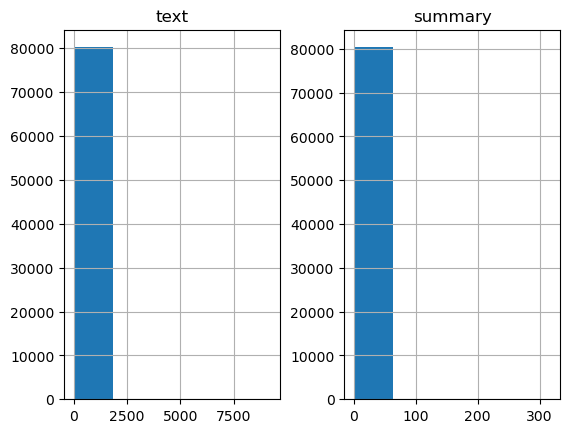

In [54]:
graph_df.hist(bins = 5)
plt.show()

# Percent of the word

In [55]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9999128605395178


In [56]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.07038378708095255


# Selecting text and summary

In [58]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

In [59]:
cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})
post_pre.head()


,text,summary
0,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু
1,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...
2,ওভারের ম্যাচ তাতেই চার আর ছয়ে রান করেছেন লাল...,ওভারের ম্যাচে ট্রিপল সেঞ্চুরি লালমনিরহাটের স্...
3,ঢাকা মহানগর আওয়ামী লীগের ভারপ্রাপ্ত সভাপতি এম ...,এম আজিজের জন্য আলীগের দোয়া মাহফিল
4,সম্প্রতি চালু হওয়া বিমান বাংলাদেশ এয়ারলাইন্স...,বিমানের টিকিট কাটতে দেশিবিদেশি কার্ড নেওয়া হচ্ছে


In [60]:
# Shape of post_pre 
post_pre.shape

(5654, 2)

In [61]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
#post_pre.head()

for i in range(3):
    print(post_pre['text'][i], '\n')
    print(post_pre['summary'][i], '\n\n') 

বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেনের নিচে কাটা পড়ে নওগাঁর সাবেক সিভিল সার্জন টি এম শাহজাহান আলীর মৃত্যু হয়েছে তাঁর বাড়ি বগুড়ার শিবগঞ্জ উপজেলার বিহার নিশ্চিন্তপুর গ্রামে প্রত্যক্ষদর্শী সান্তাহার রেলওয়ে জিআরপি থানা থেকে জানা গেছে সকাল সাড়ে নয়টার দিকে খুলনাগামী তেলবাহী একটি ট্রেন সান্তাহার রেলস্টেশনে দাঁড়িয়ে ছিল সময় ওই ট্রেনের দুই বগির মাঝখান দিয়ে পার হচ্ছিলেন শাহজাহান আলী কিন্তু ট্রেনটি ছেড়ে দিলে ঘটনাস্থলেই তিনি মারা যান শাহজাহানের পরিবারের সদস্যরা জানান তিনি ওই দিন ঢাকা যাওয়ার জন্য নওগাঁর বাঙ্গাবাড়িয়ার বাসা থেকে বের হন  

sostok ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু eostok 


যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোরে কেরোসিনের চুলা জ্বালানোর সময় দুই কর্মচারী অগ্নিদগ্ধ হয়েছেন তাঁরা হলেন আমির হোসেন হাসান তাঁদের ঢাকা মেডিকেল কলেজ হাসপাতালের বার্ন ইউনিটে চিকিৎসা দেওয়া হয়েছে বার্ন ইউনিটে আহত ব্যক্তিরা বলেন তাঁরা আমির হাসান যাত্রাবাড়ী মোড় এলাকায় মায়ের দোয়া নামের একটি রেস্তোরাঁয় কাজ করেন গতকাল ভোরে তাঁরা কেরোসিনের চুলা জ্বালানোর সময় হঠাৎ শরীরে আগুন ধরে যায় সময় 

# Splitting dataset

In [62]:
x_tr,x_val,y_tr,y_val = train_test_split(np.array(post_pre['text']), np.array(post_pre['summary']), test_size=0.1, random_state=0, shuffle=True)


# Finding word frequency for x_train and x_valid

In [63]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [64]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.29214491147525
Total Coverage of rare words: 9.799637088075933


In [65]:
len(x_tokenizer.index_word)

37899

# Tokenizer and pad sequence for x_train and x_valid

In [66]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 10502


# Finding word frequency for y_train and y_valid

In [67]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [69]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 87.63041733547352
Total Coverage of rare words: 30.684625981238927


# Tokenizer and pad sequence for y_train and y_valid

In [70]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))


Size of vocabulary in Y = 1234


# Checking Empty word and removing

In [72]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [73]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [74]:
x_tr.shape

(5065, 100)

In [75]:
y_tr.shape


(5065, 15)

In [76]:
x_val.shape

(561, 100)

In [77]:
y_val.shape

(561, 15)

# Model

In [78]:
latent_dim = 300
embedding_dim = 200

In [79]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)



# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [80]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     2100400     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [81]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [82]:
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1,
                   patience=25)

In [83]:
history=model.fit([x_tr, y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=128, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/50
40/40 [==============================] - 201s 5s/step - loss: 3.0150 - val_loss: 2.2034
Epoch 2/50
40/40 [==============================] - 182s 5s/step - loss: 2.3531 - val_loss: 2.1950
Epoch 3/50
40/40 [==============================] - 182s 5s/step - loss: 2.2934 - val_loss: 2.0804
Epoch 4/50
40/40 [==============================] - 186s 5s/step - loss: 2.1920 - val_loss: 2.0334
Epoch 5/50
40/40 [==============================] - 183s 5s/step - loss: 2.1419 - val_loss: 1.9989
Epoch 6/50
40/40 [==============================] - 182s 5s/step - loss: 2.1262 - val_loss: 1.9896
Epoch 7/50
40/40 [==============================] - 182s 5s/step - loss: 2.1186 - val_loss: 1.9918
Epoch 8/50
40/40 [==============================] - 182s 5s/step - loss: 2.1128 - val_loss: 1.9891
Epoch 9/50
40/40 [==============================] - 182s 5s/step - loss: 2.1092 - val_loss: 1.9904
Epoch 10/50
40/40 [==============================] - 181s 5s/step - loss: 2.1060 - val_loss: 1.9874
Epoch 11/

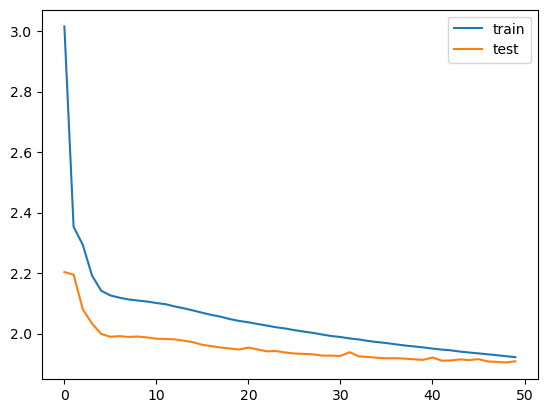

In [84]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [86]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [87]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [88]:
target_word_index

{'sostok': 1,
 'eostok': 2,
 'থেকে': 3,
 'দুই': 4,
 'শুরু': 5,
 'না': 6,
 'সঙ্গে': 7,
 'নিহত': 8,
 'গ্রেপ্তার': 9,
 'চুক্তি': 10,
 'হবে': 11,
 'আটক': 12,
 'নতুন': 13,
 'ব্যাংক': 14,
 'ব্যাংকের': 15,
 'উদ্ধার': 16,
 'মধ্যে': 17,
 'নিয়ে': 18,
 'বিরুদ্ধে': 19,
 'এক': 20,
 'তিন': 21,
 'আজ': 22,
 'লাখ': 23,
 'জন্য': 24,
 'টাকা': 25,
 'পরীক্ষা': 26,
 'দাবি': 27,
 'পুরস্কার': 28,
 'সভা': 29,
 'প্রথম': 30,
 'আহত': 31,
 'করতে': 32,
 'ঢাকা': 33,
 'বিতরণ': 34,
 'পর': 35,
 'কাল': 36,
 'হাজার': 37,
 'বন্ধ': 38,
 'করে': 39,
 'হচ্ছে': 40,
 'বাংলাদেশ': 41,
 'মামলা': 42,
 'মৃত্যু': 43,
 'ভর্তি': 44,
 'পুলিশ': 45,
 'দিন': 46,
 'বিএনপির': 47,
 'অনুষ্ঠান': 48,
 'খালেদা': 49,
 'শিক্ষা': 50,
 'লাশ': 51,
 'জন': 52,
 'চট্টগ্রামে': 53,
 'টাকার': 54,
 'নারী': 55,
 'কোটি': 56,
 'নির্বাচন': 57,
 'দেবে': 58,
 'চার': 59,
 'অ্যান্ড': 60,
 'জনের': 61,
 'শিশু': 62,
 'অব': 63,
 'নেতা': 64,
 'পেলেন': 65,
 'শতাংশ': 66,
 'কমিটি': 67,
 'পাঁচ': 68,
 'করার': 69,
 'সা': 70,
 'করা': 71,
 'মার্চ': 72,
 'সরকার': 73,
 'সিটি': 74,

In [89]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word. 
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [90]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [91]:
for i in range(0,100):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: প্রতিবছরের মতো এবারও ট্রান্সকম ফুড লিমিটেড ভিসা জন্য শতাংশ ছাড় ক্যাম্পেইন চালু করেছে বাংলাদেশে সব ধরনের ভিসা দেশের সব হাট আউটলেটে এই সুবিধা পাবেন মার্চ থেকে আগামী জুন পর্যন্ত কার্যকর থাকবে এবং স্পেশাল ছাড়া সব নিয়মিত প্রযোজ্য হবে গুলশান সেন্টারে এবং আউটলেটে এক অনুষ্ঠানে ট্রান্সকম ফুড লিমিটেডের সিইও চৌধুরী ক্যাম্পেইনের উদ্বোধন করেন ট্রান্সকম পরিবারের পরিচিত মুখ অভিনেত্রী বন্যা মির্জা সংগীতশিল্পী এবং মডেল জান্নাতুল ফেরদৌসী অনুষ্ঠানে উপস্থিত ছিলেন বিজ্ঞপ্তি 
Original summary: ভিসা জন্য ট্রান্সকম শতাংশ ছাড় 
1/1 [==============================] - 0s 28ms/step
Predicted summary:  দুই শিক্ষা সমাপনী জেএসসি পরীক্ষার্থীদের জন্য


Review: রাজধানীর রুটে কাল মঙ্গলবার থেকে বিআরটিসির মহিলা বাস সার্ভিস চালুর নির্দেশ দিয়েছেন সড়ক পরিবহন সেতুমন্ত্রী ওবায়দুল কাদের আজ সোমবার এক সংবাদ বিজ্ঞপ্তিতে কথা জানিয়ে বলা হয় প্রতিদিন সকাল সাতটায় বিআরটিসির বাস কাউন্টার থেকে বাসটি নারী যাত্রীদের নিয়ে মতিঝিলের উদ্দেশে ছেড়ে যাবে বিকেল পাঁচটায় মতিঝিল থেকে আবার উদ্দেশে বাসটি এই রুটে চলাচলকারী নারী যাত্রীদের সুবিধা

# How to increase test prediction
1. Take more training data (I din't take all data because of the limitation of the GPU)  
2. Use different LSTM for example, Bidirection LSTM and GRU
3. Use the beam search strategy for decoding the test sequence instead of using the greedy approach (argmax)
4. Remove stopword
5. Evaluate the performance using the BLEU score(https://machinelearningmastery.com/calculate-bleu-score-for-text-python/)
6. Implement pointer-generator networks and coverage mechanisms